# 1. CUDA ты идешь маленький torch

Чтобы делать вычисления на видеокартах ([CUDA](https://ru.wikipedia.org/wiki/CUDA)) и писать нейронки нам нужен новый фреймворк, у которого есть возможность сильно паралелиться и еще куча плюшек.

Таких в основе есть 2: tensorflow и pytorch. 

Мы разберем на курсе [pytorch](https://pytorch.org/tutorials/beginner/basics/intro.html) (в простонародье - торч). Tensorflow почти полностью аналогичный, только синтаксис слегка другой. Если понадобится, то можете разобраться [сами](https://www.tensorflow.org/tutorials).

* [Установка торча](https://pytorch.org/get-started/locally/)
* [Туториал торча](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html)

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
from IPython.display import Image 

## 1.1 Тензоры

### Создание

In [2]:
data    = [[1, 2],[3, 4]]
x_data  = torch.tensor(data)
x_np    = torch.tensor(np.array(data))
x_float = torch.FloatTensor(data)

x_float

tensor([[1., 2.],
        [3., 4.]])

In [3]:
x_float.numpy()

array([[1., 2.],
       [3., 4.]], dtype=float32)

In [4]:
shape = (2,3,)
rand_tensor = torch.rand(shape)
ones_tensor = torch.ones(shape)
zeros_tensor = torch.zeros(shape)

print(f"Random Tensor: \n {rand_tensor} \n")
print(f"Ones Tensor: \n {ones_tensor} \n")
print(f"Zeros Tensor: \n {zeros_tensor}")

Random Tensor: 
 tensor([[0.2724, 0.2667, 0.9094],
        [0.7509, 0.3122, 0.4097]]) 

Ones Tensor: 
 tensor([[1., 1., 1.],
        [1., 1., 1.]]) 

Zeros Tensor: 
 tensor([[0., 0., 0.],
        [0., 0., 0.]])


In [5]:
t1 = torch.cat([rand_tensor, ones_tensor , zeros_tensor], dim=1)
print(t1)

tensor([[0.2724, 0.2667, 0.9094, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000],
        [0.7509, 0.3122, 0.4097, 1.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0000]])


### Операции

In [8]:
x = torch.reshape(torch.arange(16), [4, 4])

print("X :\n%s" % x)
print("X.shape : %s\n" % (x.shape,))
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n%s" %  x, torch.transpose(x,0,1))
print("mean over cols :\n%s" % torch.mean(x.float(), axis=1)) # без флоат не срабоатет, так как не умеем автоматом тип тензора менять
print("cumsum of cols :\n%s" % torch.cumsum(x, axis=0))
print("x + numpy array: \n%s" % (x + np.arange(4)))


X :
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]])
X.shape : torch.Size([4, 4])

add 5 :
tensor([[ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16],
        [17, 18, 19, 20]])
X*X^T  :
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]) tensor([[ 0,  4,  8, 12],
        [ 1,  5,  9, 13],
        [ 2,  6, 10, 14],
        [ 3,  7, 11, 15]])
mean over cols :
tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols :
tensor([[ 0,  1,  2,  3],
        [ 4,  6,  8, 10],
        [12, 15, 18, 21],
        [24, 28, 32, 36]])
x + numpy array: 
tensor([[ 0,  2,  4,  6],
        [ 4,  6,  8, 10],
        [ 8, 10, 12, 14],
        [12, 14, 16, 18]])


#### Функции старые, а названия все новые. Страдайте


In [9]:
x ** x

tensor([[                 1,                  1,                  4,
                         27],
        [               256,               3125,              46656,
                     823543],
        [          16777216,          387420489,        10000000000,
               285311670611],
        [     8916100448256,    302875106592253,  11112006825558016,
         437893890380859375]])

## CUDA (только колаб)

In [10]:
tensor = torch.reshape(torch.arange(16), [4, 4])

if torch.cuda.is_available():
    tensor = tensor.to('cuda')
else:
    tensor = tensor.to('cpu')

In [11]:
torch.cuda.is_available()

False

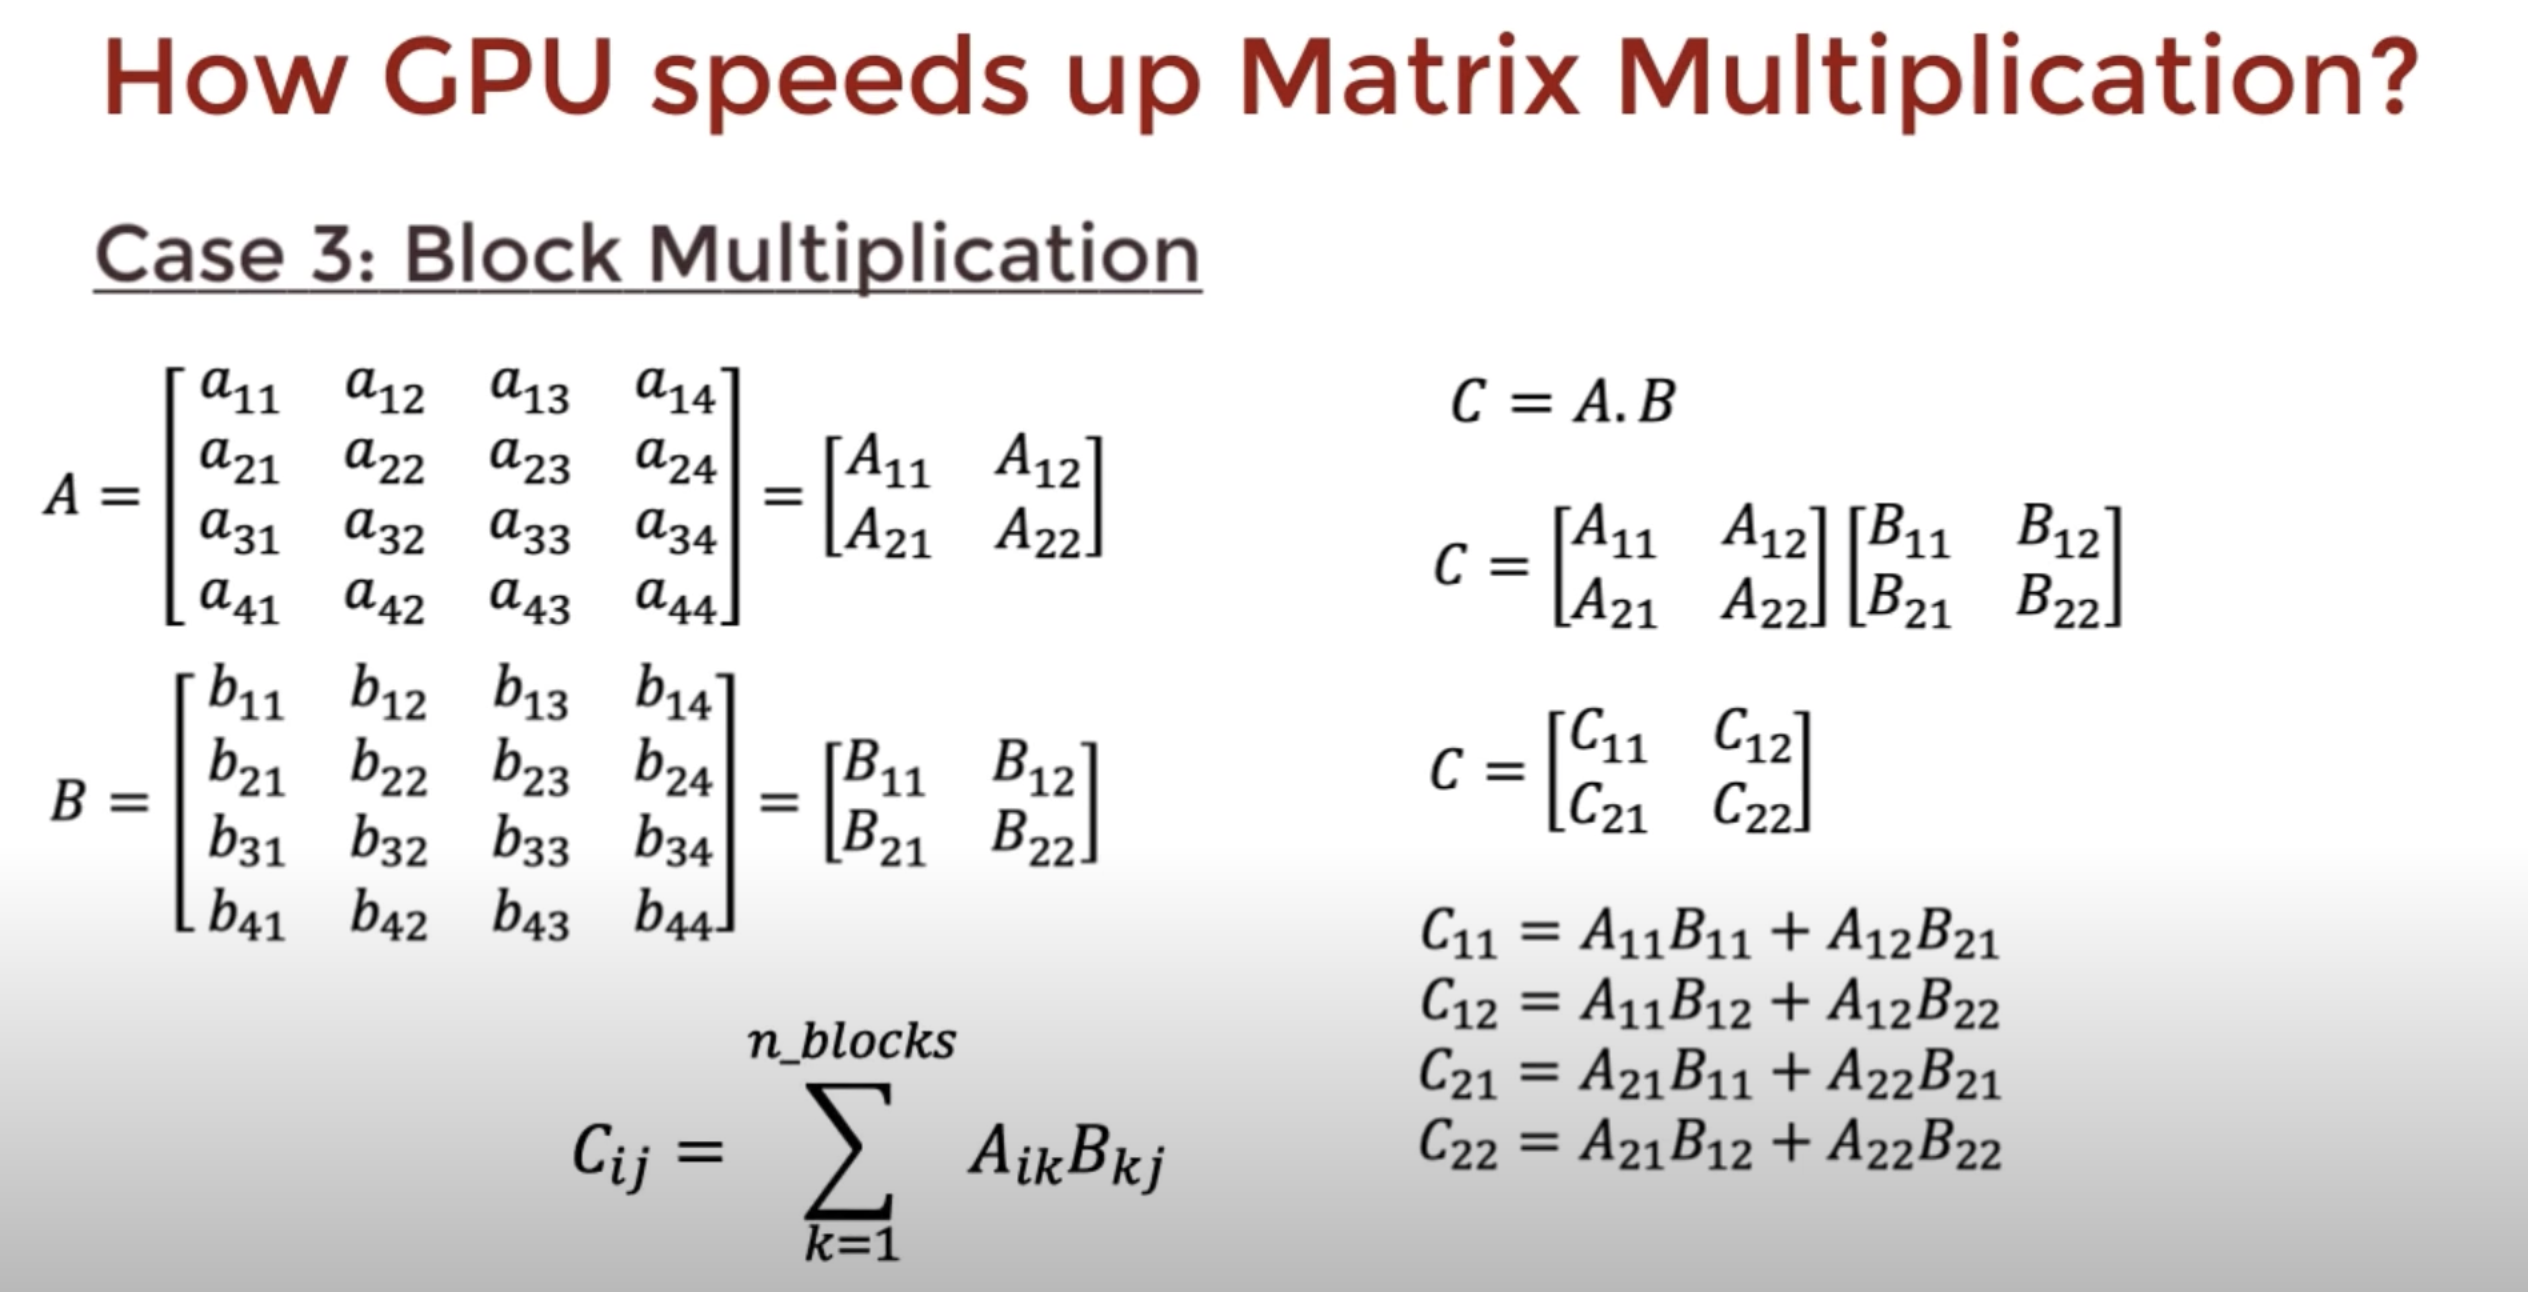

In [41]:
Image('images/gpuspeedup.png')

# 1.2 Производные (autograd)

Да, торч [умеет брать производные](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html). В отличие от студентов...

## Пример 1

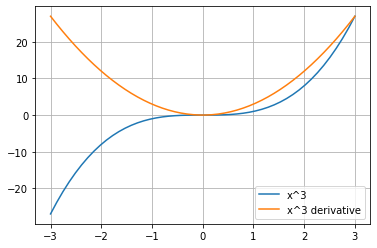

In [12]:
x = torch.linspace(-3.0, 3.0, steps=50).requires_grad_(True) #переключаем в режим градиентов
y = x**3
y.backward(gradient=torch.ones_like(y)) # 
#y.sum().backward()

x_np = x.detach().numpy() # detach убирает require_grad
y_np = y.detach().numpy()

x.grad # dy/dx

x_grad_np = x.grad.detach().numpy()

plt.plot(x_np, y_np, label="x^3")
plt.plot(x_np, x_grad_np, label="x^3 derivative")
plt.grid()
plt.legend()

* requires_grad - особый флаг тензора, при котором другим тензорам, образованным от него, передается ссылка на него и форма преобразования
* detach - `фиксирует` тензор производных в обычный тензор


## Пример 2 Смотрим на внутренности тензоров

In [15]:
x = torch.FloatTensor([1,2,3]).requires_grad_(True) #переключаем в режим градиентов
y = x**3

print(x)
print(y)
print(x.grad) # тут ничего не лежит пока не сказали волшебное слово backward

tensor([1., 2., 3.], requires_grad=True)
tensor([ 1.,  8., 27.], grad_fn=<PowBackward0>)
None


In [17]:
#y.sum().backward()
y.backward(gradient=torch.ones_like(y))

print(x)
print(y)
print(x.grad) # теперь лежит, потому что вызвали backward

tensor([1., 2., 3.], requires_grad=True)
tensor([ 1.,  8., 27.], grad_fn=<PowBackward0>)
tensor([ 3., 12., 27.])


## Пример 3 Промежуточные производные

In [23]:
x = torch.FloatTensor([1,2,3]).requires_grad_(True) #переключаем в режим градиентов
y = x**3
z = y**2

print(x)
print(y)
print(z)
print(y.grad)
print(x.grad)

tensor([1., 2., 3.], requires_grad=True)
tensor([ 1.,  8., 27.], grad_fn=<PowBackward0>)
tensor([  1.,  64., 729.], grad_fn=<PowBackward0>)
None
None


<ipython-input-23-0c074b4e5d8a>:8: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information.
  print(y.grad)


In [24]:
y.retain_grad() # чтобы взялись аргументы не у листьев
z.sum().backward()
# или так z.backward(gradient=torch.ones_like(z))

In [25]:

print('x:', x)
print('y:', y)
print('z:', z)
print('dz/dy:', y.grad)
print('dz/dy * dy/dx:', x.grad)

x: tensor([1., 2., 3.], requires_grad=True)
y: tensor([ 1.,  8., 27.], grad_fn=<PowBackward0>)
z: tensor([  1.,  64., 729.], grad_fn=<PowBackward0>)
dz/dy: tensor([ 2., 16., 54.])
dz/dy * dy/dx: tensor([   6.,  192., 1458.])


## Пример 4 Независимые переменные

$Q = 3a^2 - b^2$

In [26]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

Q = 3*a**3 - b**2

Q.backward(gradient=torch.tensor([1., 1.]))

print(a.grad)
print(b.grad)
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([36., 81.])
tensor([-12.,  -8.])
tensor([True, True])
tensor([True, True])


In [27]:
print(Q)

tensor([-12.,  65.], grad_fn=<SubBackward0>)


### Пример 5 Матричные производные
$F = Wx + b$

In [28]:
x = torch.FloatTensor(3, 1).uniform_().requires_grad_(True)
w = torch.FloatTensor(3, 3).uniform_().requires_grad_(True)
b = torch.FloatTensor(3, 1).uniform_().requires_grad_(True)


F = (w @ x).add_(b)

F.backward(gradient=torch.ones_like(F))

In [29]:
print(F)

tensor([[1.5384],
        [0.7233],
        [2.1097]], grad_fn=<AddBackward0>)


In [30]:
x.grad

tensor([[1.9729],
        [1.1883],
        [1.9940]])

In [31]:
w.grad

tensor([[0.8013, 0.7558, 0.3494],
        [0.8013, 0.7558, 0.3494],
        [0.8013, 0.7558, 0.3494]])

In [32]:
b.grad

tensor([[1.],
        [1.],
        [1.]])

## !!Пример 6 буфер градиентов 

In [34]:
x = torch.ones(4, requires_grad=True)

for epoch in range(5):
    y = 3*x.sum()
    y.backward()
    print(x.grad)
    #x.grad.zero_()

tensor([3., 3., 3., 3.])
tensor([6., 6., 6., 6.])
tensor([9., 9., 9., 9.])
tensor([12., 12., 12., 12.])
tensor([15., 15., 15., 15.])


## Граф вычислений

In [35]:
a = torch.ones(1, requires_grad=True)
w1,w2,w3,w4 = 2,3,4,5

# forward шаг
b=  w1 * a
c = w2 * a
d = w3 * b + w4 * c
L = 10 - d

In [36]:
# backward
d.retain_grad()
c.retain_grad()
b.retain_grad()

L.backward()

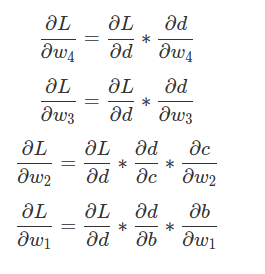

In [37]:
Image('images/graph_backward.png')

In [38]:
print(d.grad)
print(c.grad)
print(b.grad)
print(a.grad)

tensor([-1.])
tensor([-5.])
tensor([-4.])
tensor([-23.])


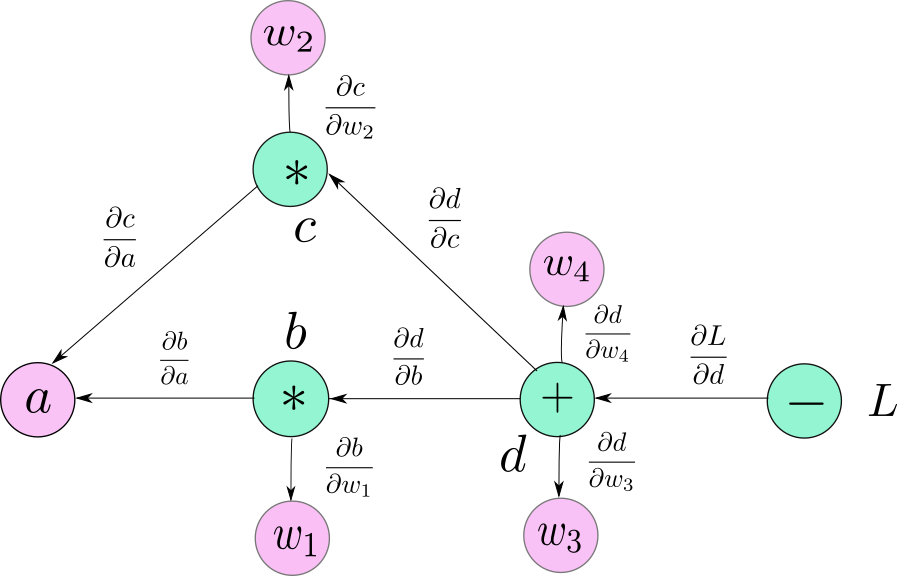

In [39]:
Image('images/full_graph.png')

#### Одно из ключевых отличий pytorch от tensorflow - в торче граф вычислений строится в онлайне (на каждый вызов форварда строится нода), а в тензорфлоу - оффлайн (только когда вся сеть записана и запущен forward по всей сети)

# Полезные ссылки
* [Видос про Autograd](https://www.youtube.com/watch?v=DbeIqrwb_dE)
* [Видео автоматическое взятие производных](https://www.youtube.com/watch?v=wG_nF1awSSY)
* [Видос про CUDA](https://www.youtube.com/watch?v=M2YWnv5cLBo)
* [Как считается производная?](https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/)
* [Сравнение torch tensor и numpy array](https://medium.com/@ashish.iitr2015/comparison-between-pytorch-tensor-and-numpy-array-de41e389c213)
* [Численное дифференцирование](https://ru.wikipedia.org/wiki/%D0%A7%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B5_%D0%B4%D0%B8%D1%84%D1%84%D0%B5%D1%80%D0%B5%D0%BD%D1%86%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5)